In [11]:
# Set project directory
import os
import sys


def project_dir():
    notebook_path = %pwd
    repo_name = "nsl_kdd"
    repo_folder = notebook_path.split(repo_name)[0]
    return os.path.join(repo_folder, repo_name)


pwd = os.getenv("PWD", project_dir())
os.environ["PWD"] = pwd
sys.path.append(pwd)

In [87]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Input, Dropout
from keras.layers.core import Dense
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from collections import Counter

import time
from data_utils import *
import umap
from sklearn.metrics import confusion_matrix


from data_utils import load_train_test_data
from src.feature_extraction import CategoricalExtractor

import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

# Utils

In [60]:
def plot_history(network_history, title, ymax=None):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history['loss'])
    plt.plot(network_history['val_loss'])
    plt.legend(['Training', 'Validation'])

    if ymax is not None:
        plt.ylim(0, ymax)
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history['accuracy'])
    plt.plot(network_history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
def run_and_measure(fun, *args, **kwargs):
    start = time.time()
    retval = fun(*args, **kwargs)
    end = time.time()
    return retval, end - start
    
    
def train_models(create_model, X_train, Y_train, X_val, Y_val, name, batch_size=8192, n_epochs=50, train=True, lr_start = 0.001, lr_patience = None, verbose = 0):
    histories = []
    models = []
    
    model = create_model(lr=lr_start)
    
    models.append(model)
    
    
    
    if train:
        callbacks = []
        if lr_patience is not None:
            callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5, patience=lr_patience, min_delta=0.00005))
            callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=lr_patience*3, restore_best_weights=True, verbose=1))
            
        history, t = run_and_measure(model.fit,
                                    X_train, 
                                    Y_train, 
                                    batch_size = batch_size, 
                                    epochs = n_epochs, 
                                    verbose = verbose,
                                    callbacks = callbacks,
                                    validation_data=(X_val, Y_val))
        histories.append(history.history)
    
        print(f"{t:0.2f} s")
        
    return histories, models

def plot_histories(histories, title, ymax=1, print_mse=True):
    plt.figure(figsize=(12, 8))
    
    for history in histories:
        plot_history(history,"aaa", ymax)

In [14]:
(X_train, X_test, Y_train, Y_test), attack_classes = load_train_test_data(pwd=pwd, return_classes=True, standardize=True, norm=False, include_categorical=True)

In [15]:
X = np.vstack([X_train, X_test])
Y = np.vstack([Y_train, Y_test])
nsl_lables = np.argmax(Y[:], axis=1)

In [20]:
extractor = CategoricalExtractor(16, root=pwd)

In [23]:
extracted_features = extractor.extract_features(X)

2022-06-05 19:21:48.147154: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-05 19:21:48.199587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
extracted_features.shape

(148517, 16)

# STFT gen

In [25]:
def stft(x: np.ndarray, nfft: int) -> np.ndarray:
    n = x.shape[0]
    rpad = nfft - x.shape[-1] % nfft
    wins = np.pad(x, ((0, 0), (0, rpad))).reshape(n, -1, nfft) * np.hanning(nfft)
    fftc = np.fft.fft(wins, n=nfft)[..., :(nfft // 2)]
    return np.abs(fftc)

(1, 3, 3)


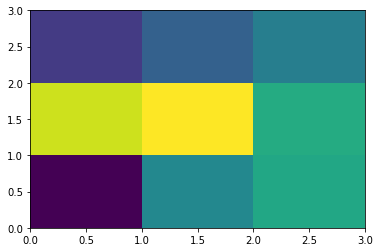

In [83]:
Sxx = stft(extracted_features[3:4], 6)
# plt.pcolormesh(Sxx[0], shading='gouraud')
plt.pcolormesh(Sxx[0])
print(Sxx.shape)
plt.show()

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(Sxx, Y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = Y)

In [46]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify = Y_train)

In [52]:
def model_v1(lr = 0.001):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(500, activation='relu', input_dim=9))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [84]:
def model_v2(lr = 0.001):
    input = Input(shape=(3,3))

    x = tf.keras.layers.Conv2D(32, 2, activation='relu')(input)
  
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

#     x = tf.keras.layers.Conv2D(64, 2, activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.MaxPooling2D(2)(x)
#     x = tf.keras.layers.Dropout(0.4)(x)

#     x = tf.keras.layers.Conv2D(128, 2, activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.MaxPooling2D(2)(x)
#     x = tf.keras.layers.Dropout(0.4)(x)


  # x = tf.keras.layers.Conv2D(256, 1, activation='relu')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.MaxPooling2D(2)(x)
  # x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Flatten()(x)


    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)

    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model

In [57]:
histories_v1, models_v1 = train_models(model_v1, X_train, Y_train, X_val, Y_val, "model v1", batch_size=8192, n_epochs=500, train=True, lr_start=0.001, lr_patience=10, verbose=1)

Epoch 1/500
 1/12 [=>............................] - ETA: 3s - loss: 1.7145 - accuracy: 0.0034

2022-06-05 19:38:03.878271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 1s 26ms/step - loss: 1.3869 - accuracy: 0.6134 - val_loss: 1.1457 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 2/500
 9/12 [=====================>........] - ETA: 0s - loss: 1.0465 - accuracy: 0.7885

2022-06-05 19:38:04.244616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 16ms/step - loss: 1.0196 - accuracy: 0.7878 - val_loss: 0.8804 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 15ms/step - loss: 0.7674 - accuracy: 0.7997 - val_loss: 0.6617 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 17ms/step - loss: 0.6077 - accuracy: 0.8328 - val_loss: 0.5629 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 16ms/step - loss: 0.5336 - accuracy: 0.8527 - val_loss: 0.5057 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 16ms/step - loss: 0.4786 - accuracy: 0.8632 - val_loss: 0.4533 - val_accuracy: 0.8713 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 21ms/step - loss: 0.4320 - accuracy: 0.8774 - val_loss: 0.4129 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 8/500
12/12 [==============================] - 0s 15ms/step - loss: 0.3947 -

Epoch 55/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0897 - accuracy: 0.9726 - val_loss: 0.0988 - val_accuracy: 0.9708 - lr: 0.0010
Epoch 56/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0902 - accuracy: 0.9720 - val_loss: 0.1005 - val_accuracy: 0.9691 - lr: 0.0010
Epoch 57/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0890 - accuracy: 0.9725 - val_loss: 0.0986 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 58/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0874 - accuracy: 0.9730 - val_loss: 0.0982 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 59/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0854 - accuracy: 0.9730 - val_loss: 0.0985 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 60/500
12/12 [==============================] - 0s 18ms/step - loss: 0.0855 - accuracy: 0.9733 - val_loss: 0.0991 - val_accuracy: 0.9689 - lr: 0.0010
Epoch 61/500
12/12 [==============================] - 0s 15ms/st

12/12 [==============================] - 0s 15ms/step - loss: 0.0693 - accuracy: 0.9785 - val_loss: 0.0845 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 108/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0676 - accuracy: 0.9789 - val_loss: 0.0765 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 109/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0649 - accuracy: 0.9801 - val_loss: 0.0752 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 110/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0633 - accuracy: 0.9805 - val_loss: 0.0757 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 111/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0626 - accuracy: 0.9812 - val_loss: 0.0754 - val_accuracy: 0.9770 - lr: 0.0010
Epoch 112/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0641 - accuracy: 0.9800 - val_loss: 0.0783 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 113/500
12/12 [==============================] - 0s 15ms/step - lo

12/12 [==============================] - 0s 15ms/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.0709 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 160/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.0681 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 161/500
12/12 [==============================] - 0s 17ms/step - loss: 0.0527 - accuracy: 0.9841 - val_loss: 0.0673 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 162/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0514 - accuracy: 0.9846 - val_loss: 0.0667 - val_accuracy: 0.9801 - lr: 0.0010
Epoch 163/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0504 - accuracy: 0.9847 - val_loss: 0.0681 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 164/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0524 - accuracy: 0.9842 - val_loss: 0.0685 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 165/500
12/12 [==============================] - 0s 15ms/step - lo

12/12 [==============================] - 0s 15ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.0636 - val_accuracy: 0.9815 - lr: 0.0010
Epoch 212/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0471 - accuracy: 0.9860 - val_loss: 0.0637 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 213/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0456 - accuracy: 0.9862 - val_loss: 0.0612 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 214/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.0635 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 215/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0444 - accuracy: 0.9866 - val_loss: 0.0609 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 216/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0447 - accuracy: 0.9865 - val_loss: 0.0624 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 217/500
12/12 [==============================] - 0s 14ms/step - lo

Epoch 263/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0388 - accuracy: 0.9883 - val_loss: 0.0617 - val_accuracy: 0.9835 - lr: 5.0000e-04
Epoch 264/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0387 - accuracy: 0.9880 - val_loss: 0.0597 - val_accuracy: 0.9836 - lr: 5.0000e-04
Epoch 265/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0388 - accuracy: 0.9882 - val_loss: 0.0609 - val_accuracy: 0.9834 - lr: 5.0000e-04
Epoch 266/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0380 - accuracy: 0.9886 - val_loss: 0.0590 - val_accuracy: 0.9839 - lr: 5.0000e-04
Epoch 267/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0385 - accuracy: 0.9887 - val_loss: 0.0602 - val_accuracy: 0.9830 - lr: 5.0000e-04
Epoch 268/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0382 - accuracy: 0.9885 - val_loss: 0.0604 - val_accuracy: 0.9834 - lr: 5.0000e-04
Epoch 269/500
12/12 [=============

Epoch 314/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0347 - accuracy: 0.9893 - val_loss: 0.0576 - val_accuracy: 0.9847 - lr: 2.5000e-04
Epoch 315/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0346 - accuracy: 0.9894 - val_loss: 0.0577 - val_accuracy: 0.9846 - lr: 2.5000e-04
Epoch 316/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0347 - accuracy: 0.9894 - val_loss: 0.0579 - val_accuracy: 0.9846 - lr: 2.5000e-04
Epoch 317/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0348 - accuracy: 0.9892 - val_loss: 0.0577 - val_accuracy: 0.9846 - lr: 2.5000e-04
Epoch 318/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0583 - val_accuracy: 0.9842 - lr: 2.5000e-04
Epoch 319/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.0577 - val_accuracy: 0.9847 - lr: 2.5000e-04
Epoch 320/500
12/12 [=============

Epoch 365/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0332 - accuracy: 0.9898 - val_loss: 0.0574 - val_accuracy: 0.9848 - lr: 6.2500e-05
Epoch 366/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0574 - val_accuracy: 0.9847 - lr: 6.2500e-05
Epoch 367/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.0573 - val_accuracy: 0.9849 - lr: 6.2500e-05
Epoch 368/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0332 - accuracy: 0.9899 - val_loss: 0.0574 - val_accuracy: 0.9848 - lr: 6.2500e-05
Epoch 369/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 0.0575 - val_accuracy: 0.9847 - lr: 6.2500e-05
Epoch 370/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0333 - accuracy: 0.9899 - val_loss: 0.0578 - val_accuracy: 0.9846 - lr: 6.2500e-05
Epoch 371/500
12/12 [=============

Epoch 416/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9848 - lr: 7.8125e-06
Epoch 417/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9848 - lr: 7.8125e-06
Epoch 418/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9848 - lr: 7.8125e-06
Epoch 419/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0574 - val_accuracy: 0.9847 - lr: 7.8125e-06
Epoch 420/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9848 - lr: 7.8125e-06
Epoch 421/500
12/12 [==============================] - 0s 15ms/step - loss: 0.0329 - accuracy: 0.9900 - val_loss: 0.0573 - val_accuracy: 0.9848 - lr: 3.9063e-06
Epoch 422/500
12/12 [=============

<Figure size 864x576 with 0 Axes>

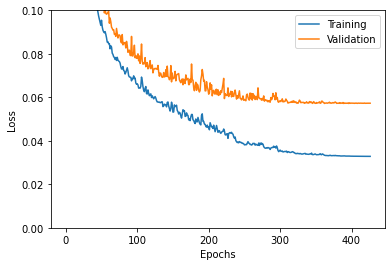

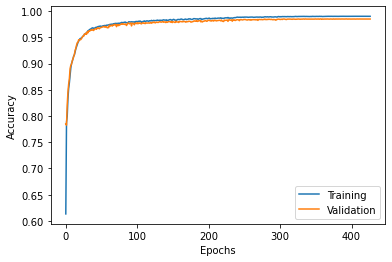

In [61]:
plot_histories(histories_v1, "model v1", 0.1)

In [66]:
predictions = models_v1[0].predict(X_test)

Text(33.0, 0.5, 'True')

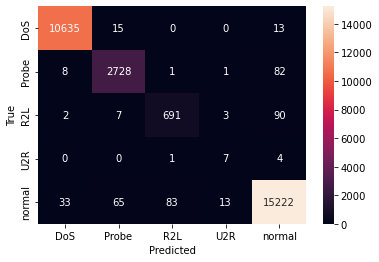

In [67]:
sns.heatmap(confusion_matrix(np.argmax(predictions, axis=1), np.argmax(Y_test, axis=1)), annot=True, fmt="d", xticklabels=attack_classes, yticklabels=attack_classes)
plt.xlabel("Predicted")
plt.ylabel("True")

In [88]:
histories_v2, models_v2 = train_models(model_v2, X_train, Y_train, X_val, Y_val, "model v2", batch_size=8192, n_epochs=500, train=True, lr_start=0.001, lr_patience=10, verbose=1)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 3, 3)